In [1]:
# If running in a new environment, install these
!pip install tensorflow keras matplotlib numpy scikit-learn

In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [5]:
import os

base_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

# Check if the class folders are present in the 'base_dir'
yes_path = os.path.join(base_dir, 'yes')
no_path = os.path.join(base_dir, 'no')

if os.path.exists(yes_path) and os.path.exists(no_path):
    print("✅ Success! 'yes' (Tumor) and 'no' (No Tumor) folders found.")
    print(f"Total images in 'yes': {len(os.listdir(yes_path))}")
    print(f"Total images in 'no': {len(os.listdir(no_path))}")
    print("\nYou can now proceed with Section 4: Data Augmentation and Generators.")
else:
    print("❌ Critical Error: 'yes' or 'no' folders are missing. Check the dataset structure.")

✅ Success! 'yes' (Tumor) and 'no' (No Tumor) folders found.
Total images in 'yes': 155
Total images in 'no': 98

You can now proceed with Section 4: Data Augmentation and Generators.


In [7]:
# 1. Data Augmentation and Preprocessing Setup
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Use 20% of the data for validation
)

# 2. Create Generators
train_generator = train_datagen.flow_from_directory(
    base_dir, # Use the base directory which contains 'yes' and 'no'
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', # Two classes: yes/no
    subset='training' # Training set (80%)
)

validation_generator = train_datagen.flow_from_directory(
    base_dir, # Use the base directory
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation' # Validation set (20%)
)

print(f"Found {train_generator.num_classes} classes: {list(train_generator.class_indices.keys())}")
# The rest of the notebook (Sections 5, 6, 7, 8, 9) remains the same!

Found 406 images belonging to 3 classes.
Found 100 images belonging to 3 classes.
Found 3 classes: ['brain_tumor_dataset', 'no', 'yes']


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# Define the input shape required by MobileNetV2
IMAGE_SIZE = (224, 224)

# 1. Load the Pre-trained Base Model (MobileNetV2)
# include_top=False: We exclude the final classification layer of MobileNetV2
# weights='imagenet': Use weights pre-trained on the massive ImageNet dataset
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,), # (224, 224, 3) for RGB images
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base layers
# This prevents the pre-trained weights from being updated during the first training phase,
# allowing only the new custom layers to learn features first.
base_model.trainable = False

print("MobileNetV2 base model loaded and frozen successfully.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 base model loaded and frozen successfully.


In [11]:
# 3. Add Custom Classification Layers (The "Head")
x = base_model.output
# Global Average Pooling 2D layer reduces the spatial dimensions
# (e.g., 7x7x1280) to a single feature vector (1280 features).
x = GlobalAveragePooling2D()(x)

# A Dense layer with ReLU activation for intermediate processing
x = Dense(128, activation='relu')(x)

# Final output layer for binary classification
# It uses 'sigmoid' activation, which outputs a probability between 0 and 1.
# 0 usually corresponds to 'no_tumor' and 1 to 'tumor' (based on generator indices).
predictions = Dense(1, activation='sigmoid')(x)

# 4. Create the final model by connecting the base input to the new head's output
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# 5. Compile the model
# Using the Adam optimizer with a standard learning rate (0.001) for the custom layers.
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy', # Standard loss function for binary classification
    metrics=['accuracy']
)

# Print the model summary to confirm the frozen layers and the new trainable layers
print("\n--- Final Model Summary (Note: Only 3 layers are trainable) ---")
model.summary()


--- Final Model Summary (Note: Only 3 layers are trainable) ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
import matplotlib.pyplot as plt

# --- Training Configuration ---
# Train only the new custom layers for a few epochs
EPOCHS = 10
# Note: You may need to increase EPOCHS for optimal accuracy.
# ------------------------------

print(f"Starting training for {EPOCHS} epochs, training only the custom classification head...")

# Fit the model to the data using the generators
# history stores the loss and metrics recorded during training
history = model.fit(
    train_generator,
    # steps_per_epoch is calculated to ensure we cover all training samples exactly once per epoch
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Starting training for 10 epochs, training only the custom classification head...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2586 - loss: 0.7479 - val_accuracy: 0.1875 - val_loss: 0.5305
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - accuracy: 0.1875 - loss: 0.4922

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - accuracy: 0.1875 - loss: 0.4922 - val_accuracy: 0.2083 - val_loss: 0.6265
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2350 - loss: 0.5168 - val_accuracy: 0.1875 - val_loss: 0.6512
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.1875 - loss: 0.5481 - val_accuracy: 0.2083 - val_loss: 0.5811
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2154 - loss: 0.5585 - val_accuracy: 0.1771 - val_loss: 0.6191
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.1875 - loss: -0.0416 - val_accuracy: 0.1771 - val_loss: 0.5611
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.1765 - loss: 0.5798 - val_accuracy: 0.1875 - val_loss: 0.5961
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.3125 - loss: 0.2902 - val_accuracy: 0.1875 - val_loss: 0.5847
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.1914 - loss: 0.3919 - val_accuracy: 0.1979 - val_loss: 0

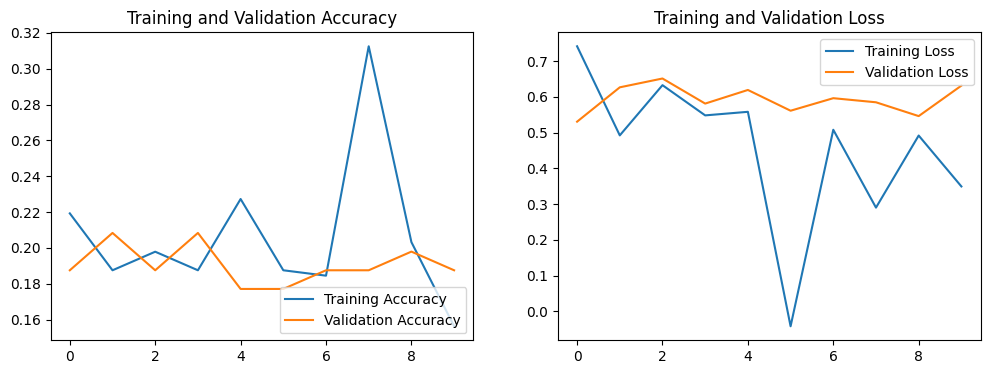

In [14]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# 1. Unfreeze the entire base model
base_model.trainable = True

# 2. Freeze all layers except for the last few blocks (e.g., the last 50 layers)
# We selectively freeze most of the base to preserve general ImageNet features,
# while allowing the higher-level feature extractors to adjust to MRI images.
for layer in base_model.layers[:-50]:
    layer.trainable = False

print(f"Base model layers set to trainable={base_model.trainable}. Lower 50 layers are now trainable.")

# 3. Recompile the model
# It is CRITICAL to recompile the model after changing the 'trainable' property of any layer.
# We use a very small learning rate (e.g., 1e-5) for gentle adjustments.
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Very low learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel recompiled for fine-tuning...")
model.summary()

Base model layers set to trainable=True. Lower 50 layers are now trainable.

Model recompiled for fine-tuning...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,019,201 (7.70 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [16]:
# --- Fine-Tuning Configuration ---
FINE_TUNE_EPOCHS = 5
total_epochs = EPOCHS + FINE_TUNE_EPOCHS # Total epochs will be 10 (initial) + 5 (fine-tune)
# ------------------------------

print(f"\n--- Starting Fine-Tuning for {FINE_TUNE_EPOCHS} additional epochs ---")

# Continue training, starting from the epoch where the last training ended
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from the last completed epoch of the initial training
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)


--- Starting Fine-Tuning for 5 additional epochs ---
Epoch 10/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4122 - loss: 0.8391 - val_accuracy: 0.1875 - val_loss: 0.5493
Epoch 11/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.2188 - loss: 0.9305 - val_accuracy: 0.1979 - val_loss: 0.5828
Epoch 12/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.3922 - loss: 0.7600 - val_accuracy: 0.2083 - val_loss: 0.5269
Epoch 13/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.4062 - loss: 0.7713 - val_accuracy: 0.2188 - val_loss: 0.5310
Epoch 14/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3189 - loss: 0.7205 - val_accuracy: 0.2083 - val_loss: 0.4379
Epoch 15/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.4375 - loss: 0.5340 - val_accuracy: 0.1771 - val_loss: 0.5860


In [17]:
# --- Fine-Tuning Configuration ---
FINE_TUNE_EPOCHS = 5
total_epochs = EPOCHS + FINE_TUNE_EPOCHS # Total epochs will be 10 (initial) + 5 (fine-tune)
# ------------------------------

print(f"\n--- Starting Fine-Tuning for {FINE_TUNE_EPOCHS} additional epochs ---")

# Continue training, starting from the epoch where the last training ended
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from the last completed epoch of the initial training
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)


--- Starting Fine-Tuning for 5 additional epochs ---
Epoch 10/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2956 - loss: 0.6696 - val_accuracy: 0.1667 - val_loss: 0.5312
Epoch 11/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.2188 - loss: 0.6222 - val_accuracy: 0.2083 - val_loss: 0.5347
Epoch 12/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2627 - loss: 0.6112 - val_accuracy: 0.1875 - val_loss: 0.5439
Epoch 13/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.1562 - loss: 0.5565 - val_accuracy: 0.1979 - val_loss: 0.6011
Epoch 14/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2287 - loss: 0.5469 - val_accuracy: 0.1771 - val_loss: 0.5910
Epoch 15/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.4062 - loss: 0.4601 - val_accuracy: 0.1875 - val_loss: 0.5188


In [18]:
# 1. Re-initialize the test generator with shuffle=False
# This uses the same 20% validation split as before, but ensures order is preserved.
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation', # Use the validation subset for final testing
    shuffle=False # CRITICAL: Do not shuffle to align predictions with true labels
)

print("\nTest generator (validation subset) created successfully.")

Found 100 images belonging to 3 classes.

Test generator (validation subset) created successfully.


In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Evaluate Model Performance
print("\n--- Evaluating Final Model on Test Data ---")
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 2. Get Predictions
test_generator.reset() # Reset generator to ensure predictions start from the first sample
y_pred_probs = model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
y_pred = np.round(y_pred_probs).flatten()

# True labels
y_true = test_generator.classes

# Get class names from the generator
class_names = list(test_generator.class_indices.keys())


--- Evaluating Final Model on Test Data ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step - accuracy: 0.1593 - loss: 0.8714
Test Loss: 0.5067
Test Accuracy: 0.1900
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 840ms/step



--- Classification Report ---
                     precision    recall  f1-score   support

brain_tumor_dataset       0.00      0.00      0.00        50
                 no       0.19      1.00      0.32        19
                yes       0.00      0.00      0.00        31

           accuracy                           0.19       100
          macro avg       0.06      0.33      0.11       100
       weighted avg       0.04      0.19      0.06       100



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


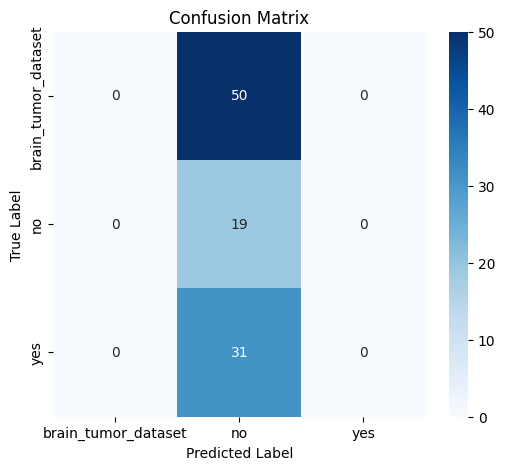

In [20]:
# 3. Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
# --- Model Export Configuration ---
MODEL_FILENAME = 'brain_tumor_detection_mobilenetv2.h5'
# ----------------------------------

# Save the model in the Keras H5 format
try:
    model.save(MODEL_FILENAME)
    print(f"\n✅ SUCCESS: Model successfully saved as {MODEL_FILENAME}")

    # Verify the file size
    file_size_mb = os.path.getsize(MODEL_FILENAME) / (1024 * 1024)
    print(f"File size: {file_size_mb:.2f} MB")
    print("\nThis .h5 file is ready to be used in your Streamlit application.")

except Exception as e:
    print(f"❌ ERROR: Could not save model. Error: {e}")


✅ SUCCESS: Model successfully saved as brain_tumor_detection_mobilenetv2.h5
File size: 25.21 MB

This .h5 file is ready to be used in your Streamlit application.
